Книжному интернет-магазину необходимо уметь предсказывать объём заказов, чтобы выделить необходимое количество сотрудников на сбор и упаковку и уменьшить задержки. Вам предстоит решить задачу предсказания товарооборота этого магазина.

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import statsmodels.api as sm

from datetime import datetime

df = pd.read_csv("tovar_moving.csv",  index_col=['date'], parse_dates=['date'], dayfirst=False) # считываем датасет
df.head() 

,qty
date,
2009-12-25,72314.0
2009-12-26,66586.0
2009-12-27,125199.0
2009-12-28,91544.0
2009-12-29,76995.0


ПРОВЕРКА НА СЕЗОННОСТЬ/ТРЕНД

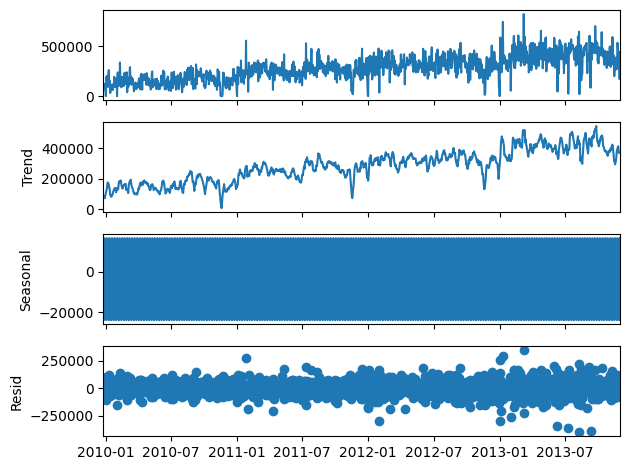

In [3]:
#импортируем библиотеку 
from statsmodels.tsa.seasonal import seasonal_decompose
#производим декомпозицию временного ряда 
decomposition = seasonal_decompose(df)
fig = decomposition.plot()

СОЗДАЕМ ТЕСТОВУЮ И ТРЕНИРОВОЧНУЮ ВЫБОРКУ (В НАШЕМ СЛУЧАЕ ПОСЛЕДНИЙ ЭЛЕМЕНТ В ТЕСТОВУЮ)

In [4]:
test_df = df.iloc[-1]
train_df = df.iloc[:-1]

ТЕПЕРЬ ПРИМЕНИМ ЭКСПОНЕНЦИАЛЬНОЕ СГЛАЖИВАНИЕ ДЛЯ ДАТАСЕТА

In [19]:
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(train_df)
alpha = 0.7
model = ses.fit(smoothing_level = alpha, optimized = False)
exp_pred = model.forecast(1)
exp_pred

c:\Users\alexm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


2013-12-02    225015.522647
Freq: D, dtype: float64

ПРОВЕРЯЕМ НА СТАЦИОНАРНОСТЬ

In [20]:
def stat_test(df):
    test = sm.tsa.adfuller(df)
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if test[0]> test[4]['5%']: 
        print ('есть единичные корни, ряд не стационарен')
    else:
        print ('единичных корней нет, ряд стационарен')

stat_test(train_df)

adf:  -2.255302641033794
p-value:  0.18678903123416657
Critical values:  {'1%': -3.434973278556316, '5%': -2.8635818545830376, '10%': -2.567857072940785}
есть единичные корни, ряд не стационарен


ЕСЛИ, КАК В НАШЕМ СЛУЧАЕ, РЯД НЕ СТАЦИОНАРЕН, нужно Получить новый ряд посредством взятия разности otg1diff = df.diff(periods=1).dropna() и снова провести тест на стационарность

In [21]:
otg1diff = df.diff(periods=1).dropna()
test1 = sm.tsa.adfuller(otg1diff)
print ('adf: ', test1[0])
print ('p-value: ', test1[1])
print ('Critical values: ', test1[4])
if test1[0]> test1[4]['5%']: 
    print ('ряд нестационарен')
else:
    print ('ряд стационарен')

adf:  -13.82183986522668
p-value:  7.878856681049073e-26
Critical values:  {'1%': -3.4349700122033804, '5%': -2.8635804131233096, '10%': -2.567856305330816}
ряд стационарен


ТЕПЕРЬ СТРОИМ КОЛЛЕЛОГРАММЫ


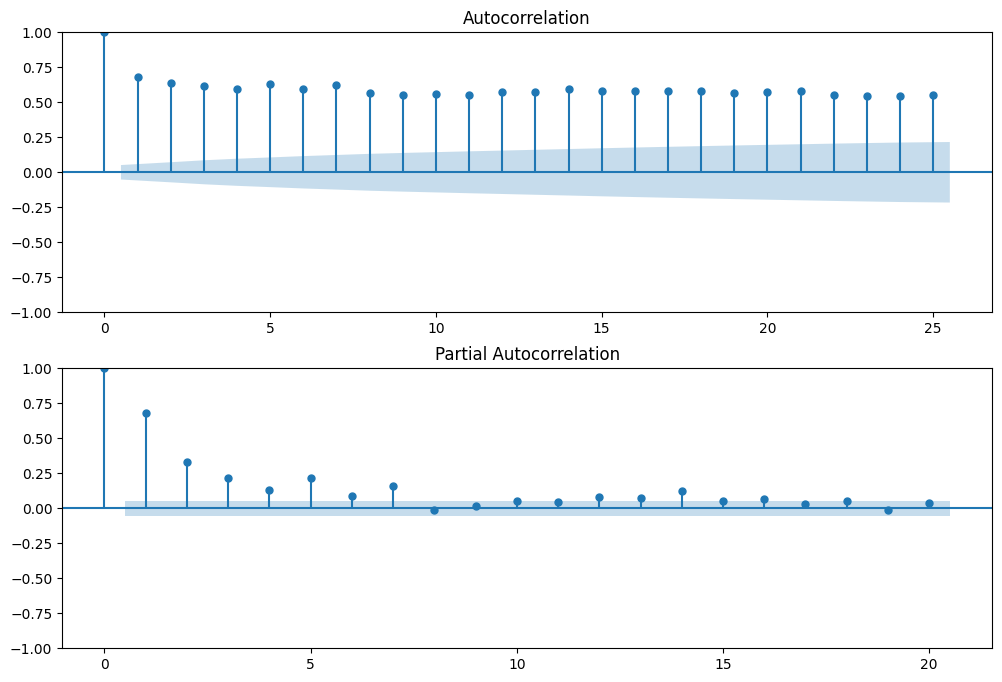

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_df.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_df, lags=20, ax=ax2)

ПАРАМЕТР Р ВЫБИРАЕТСЯ ИЗ РЕЗУЛЬТАТОВ ЧАСТИЧНОЙ АВТОКОРРЕЛЯЦИИ, У НАС ЭТО 7

ОБУЧАЕМ МОДЕЛЬ

In [23]:
p = 7

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AutoReg

ar_model = AutoReg(train_df, lags=p).fit()
print(ar_model.summary())

ar_pred = ar_model.predict(start=len(train_df), end=(len(train_df)), dynamic=False)
ar_pred

                            AutoReg Model Results                             
Dep. Variable:                    qty   No. Observations:                 1438
Model:                     AutoReg(7)   Log Likelihood              -18187.904
Method:               Conditional MLE   S.D. of innovations          80096.504
Date:                Fri, 19 Jan 2024   AIC                          36393.808
Time:                        09:05:24   BIC                          36441.203
Sample:                    01-01-2010   HQIC                         36411.506
                         - 12-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.606e+04   6125.181      4.254      0.000    1.41e+04    3.81e+04
qty.L1         0.2917      0.026     11.169      0.000       0.241       0.343
qty.L2         0.1248      0.027      4.585      0.0

c:\Users\alexm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\alexm\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


2013-12-02    345269.605384
Freq: D, dtype: float64

УЗНАЕМ БЫЛИ ЛИ МЕТОД AR БОЛЕЕ ЧЕТКИМ ЧЕМ СГЛАЖИВАНИЕ

In [24]:
from sklearn.metrics import mean_squared_error

mean_squared_error(test_df, ar_pred) < mean_squared_error(test_df, exp_pred)

True